# Fonction tester

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator, Full_Diff_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  'Data2'#sCST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Prepross

In [2]:
seed=0
batch_size=32
np.random.seed(seed)
D = [Load_FLX_dict()]
D2 = []
##### Kernels
Klist0 =[]
def identity(x):
    return(x)
def Log(x): 
    return(np.log(x))
def Plank(x):
    return(1/(np.exp(1/x) -1 ))

Klist0 = [] #[ FKernel(Log, ['q'], 1), FKernel(Plank, ['t'], 250)]
Klist = []
#Klist = [FKernel(func=identity, var=['t'])]
Klist = Klist + [ProdKernel([('pl','ts')])]
# V
V = [VarSuppression(['pl', 'rl', 'ri','ts'])]

fit_genator = Full_Diff_Generator(folder=data_folder, batch_size=10*batch_size, chosen_var=['flxd', 'flxu'],
                                  train=True, preprocess_x=D+Klist0)
normal_generator = Basic_Generator(folder=data_folder, batch_size=batch_size)

#D2 = [DictPrepross(['o3','pl','q','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True),Level_Normalizer(False)] )]
D2 = [DictPrepross(['o3','pl','q'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(True)] )]
D3_0 = [DictPrepross(['Logq'], [Normalizer()] )]
D4 = [DictPrepross(['Logq'], [Level_Normalizer(False)] )]
D3 = D3_0+D4

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['q'].fit(fit_genator[0][0][:,:,4])
#D3[0]['Logq'].fit(fit_genator[0][0][:,:,-1])
#D3[1]['Logq'].fit(fit_genator[0][0][:,:,-1])

del(normal_generator)
del(fit_genator)

##### Full Preprocessing :
#FP = Klist0 + D + Klist + D2  + D3 + V 
FP = Klist0 + D + Klist + D2  +  V 

##### b_size
batch_size= 64


train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1)
validation_generator = Full_Diff_Generator(folder='Data', batch_size=batch_size, train=False, 
                                             preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=1, custom_b_p_e= 500)
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)
lev=72

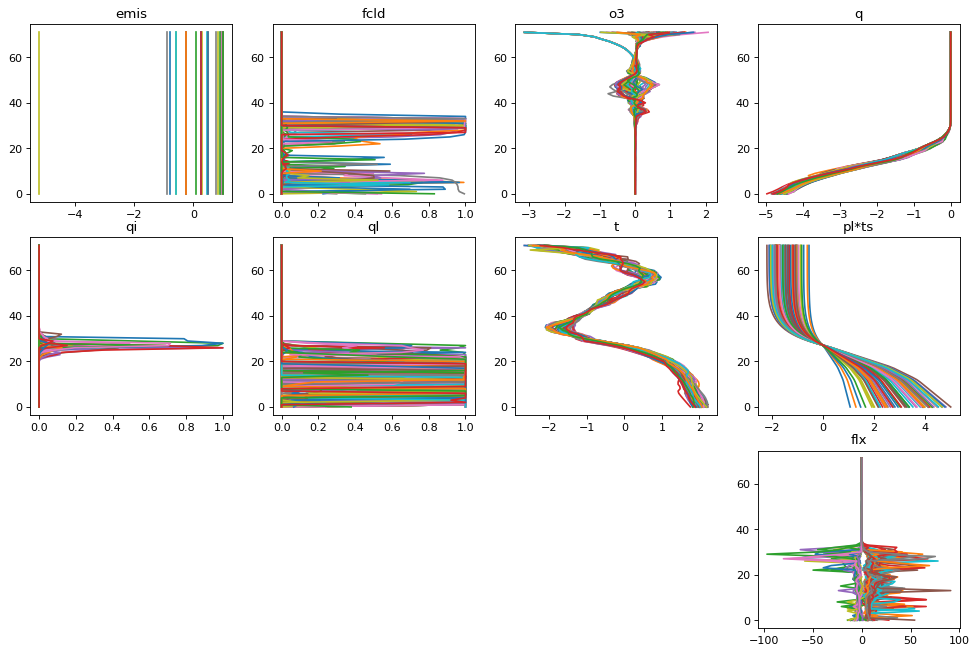

In [3]:
x,y = train_generator[0]
Plot_Batch(x,y,header_x)

### Model construct

In [4]:
from architectures import AE, Unet_Act_Double
import keras
from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler, Divide_Recombine
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
from architectures_utils import Activation_Generator
import keras.backend as K
from keras import optimizers
from keras.layers import Dropout
import datetime

# Must be identical to list_of AE1 for the 2 last elements of the list
#modelname = 'TrainedModels/'+'20190606154031AE'
#M.load_weights(modelname)

list_of_filters_ae =  [[32,32, 32], [32, 40, 50, 75, 100, 150], [40, 20, 10], [50, 50, 100, 100, 100, 100], [10]]
list_of_kernel_ae =  [[10, 10, 5], [2, 5, 2, 5, 2, 4], [], [3, 4, 3, 5, 3, 6], [5]]
list_of_activations_ae =  [['elu', 'elu', 'elu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu', 'relu', 'relu'], ['relu', 'relu', 'relu', 'relu', 'relu', 'relu'], ['relu']]

params_ae = [0.01]
M_unet =  AE(list_of_kernel_ae, list_of_filters_ae, list_of_activations_ae,
                         params_ae, Div=3, lev=CST.lev(CST), in_channel=in_channel)

M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_f = Divide_Recombine(o_channel, list_of_filters_ae[-1][-1], lev=lev)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_unet); M.layers[-1].name = 'Unet'
M.add(M_f); M.layers[-1].name = 'Div_Rec'

M_unet.summary()

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_100", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_101", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))
/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures.py:196: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(2, padding="same", name="AVG_102", strides=2)`
  Conv_l1.append(MaxPooling1D(2, padding='same', stride=2, name=Name('AVG', i+100))(Conv_l1[-1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Origin_Input (InputLayer)    (None, 72, 8)             0         
_________________________________________________________________
Conv_0 (Conv1D)              (None, 72, 32)            2560      
_________________________________________________________________
elu_0 (ELU)                  (None, 72, 32)            0         
_________________________________________________________________
Conv_1 (Conv1D)              (None, 72, 32)            10240     
_________________________________________________________________
elu_1 (ELU)                  (None, 72, 32)            0         
_________________________________________________________________
Conv_2 (Conv1D)              (None, 72, 32)            5120      
_________________________________________________________________
elu_2 (ELU)                  (None, 72, 32)            0         
__________

/home/victor/Documents/Stage/FLXmodel/FLX_NN_emulation/architectures_simples.py:29: UserWarning: Update your `AveragePooling1D` call to the Keras 2 API: `AveragePooling1D(22, padding="same", strides=5)`
  Avg = AveragePooling1D(pooling, padding='same', stride=avg)(Up)


In [7]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

def Up_Down_loss(y_true, y_pred):
    E = flxd_loss(y_true, y_pred)
    E += flxu_loss(y_true, y_pred)
    return E

ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=True, baseline=35)
prefix = '20190607122913U_AE'

LH = LossHistory(frequency=train_generator.batch_per_file, losses=['flxu_loss', 'flxd_loss', 'loss'])
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6, amsgrad=False)
M.compile(loss=Up_Down_loss, optimizer=Adam, metrics=[flxd_loss,flxu_loss])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Upsampler (Model)            (None, 72, 8)             0         
_________________________________________________________________
Unet (Model)                 (None, 72, 10)            864195    
_________________________________________________________________
Div_Rec (Model)              (None, 72, 2)             103824    
Total params: 968,019
Trainable params: 968,019
Non-trainable params: 0
_________________________________________________________________


In [8]:
M.load_weights('TrainedModels/'+prefix)

In [9]:
from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, y in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('pred_'+prefix,V)

100%|██████████| 25/25 [07:22<00:00, 18.45s/it]


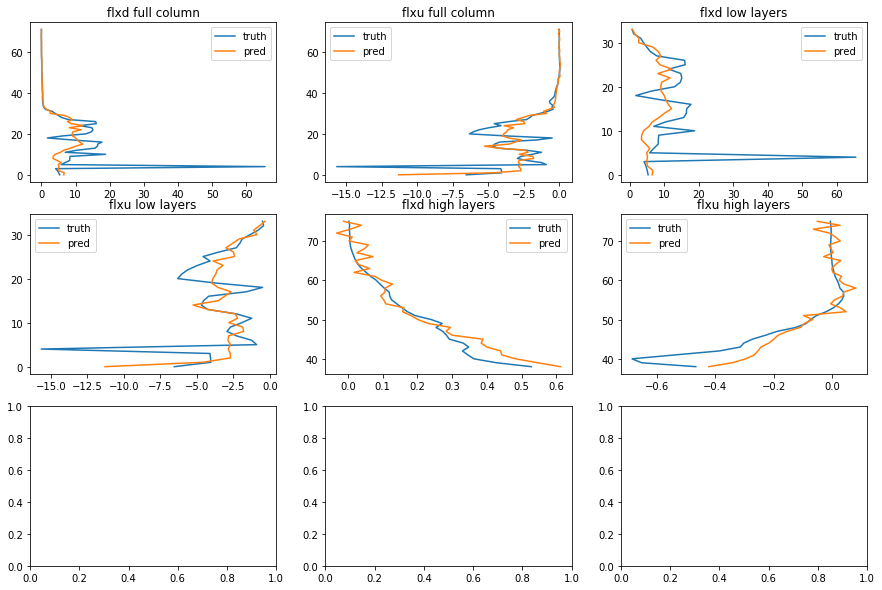

<Figure size 1080x576 with 0 Axes>

In [15]:
from utils import Plot_triple_diff_separated, F_and_plots

x,y = train_generator[5]
y0 = M.predict(x)
F = F_and_plots(shape=(3,3), figsize=(15,10))
Plot_triple_diff_separated(F, y,y0,header_y, j=0, sep=38)

In [18]:
print(np.mean(K.get_value(Up_Down_loss(y,y0))))

63.00113


In [44]:
train_generator =  Full_Diff_Generator(folder=data_folder, batch_size=1944*batch_size, train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)

def Get_T(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(x[:,-1,-2])
    T = np.array(T) 
    return(T)

def Get_Cloud(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(np.sum(x[:,:, 1], axis=1))
    T = np.array(T)
    return(T)

def Get_Emis(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(x[:,0, 0])
    T = np.array(T)
    return(T)

def Get_Cloud2(generator):
    t=0
    T=[]
    for x, y in generator:
        T.append(np.sum(x[:,:, 4]+x[:,:, 5], axis=1))
    T = np.array(T)
    return(T)
#E = Get_Emis(train_generator)
T = Get_T(train_generator)
C = Get_Cloud(train_generator)
V = np.load('loss'+prefix+'.npy')
Q = Get_Cloud2(train_generator)
xdim = train_generator.dimensions['x']
ydim = train_generator.dimensions['y']

In [46]:
from utils import reconstruct
V = V.reshape(V.shape[0], ydim,xdim)
T = T.reshape(T.shape[0], ydim,xdim)
C = C.reshape(C.shape[0], ydim,xdim)
Q = Q.reshape(Q.shape[0], ydim,xdim)
V = reconstruct(V)
T = reconstruct(T)
C = reconstruct(C)
Q = reconstruct(Q)

(720, 4320)
(720, 4320)
(720, 4320)
(720, 4320)


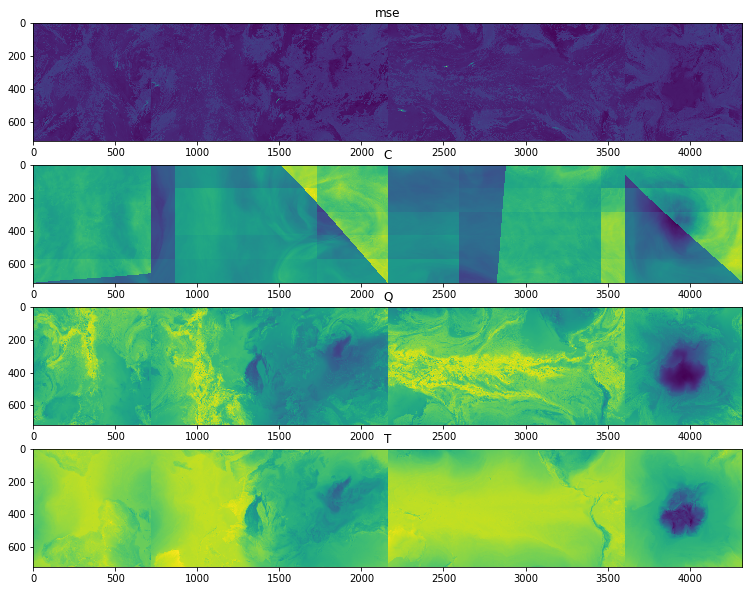

In [49]:
from utils import F_and_plots

F = F_and_plots(shape=(4,1), figsize=(15,10))
F[0].imshow(np.log(V)); F[0].set_title('mse');
F[1].imshow(C); F[1].set_title('C');
F[2].imshow(Q); F[2].set_title('Q');
F[3].imshow(T); F[3].set_title('T');

In [48]:
print(np.corrcoef(V.flatten(),T.flatten()), '\n', '\n', 
np.corrcoef(V.flatten(),C.flatten()), '\n','\n', 
np.corrcoef(V.flatten(),Q.flatten()) )

[[ 1.00000000e+00 -8.15619159e-04]
 [-8.15619159e-04  1.00000000e+00]] 
 
 [[ 1.00000000e+00 -3.54487217e-04]
 [-3.54487217e-04  1.00000000e+00]] 
 
 [[ 1.         -0.00149709]
 [-0.00149709  1.        ]]


In [54]:
#np.mean(np.sqrt(V))
np.sqrt(np.mean(V))

455.29249470496836

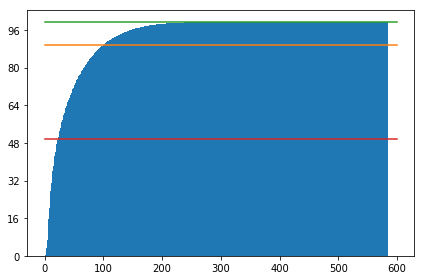

In [70]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
bins = 500
ax.hist(V.flatten(), cumulative=True, bins=bins);
# We can also normalize our inputs by the total number of counts
#axs[1].hist(x, bins=n_bins, density=True)
# Now we format the y-axis to display percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{}'.format(int(100*x/len(V.flatten()))) for i,x in enumerate(vals)])
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*0.9)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*1)
ax.plot(np.arange(bins+100), np.ones(bins+100)*len(V.flatten())*0.5)